In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from postdocsalary.paths import DATA_DIR, ensure_dir
import urllib.request

<ipython-input-2-37777429a894>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from postdocsalary.paths import save_fig, FIGURE_DIR

### Home prices

In [4]:
regions = [
    "Boston city",
    "New York County",
    "Cook County",
    "Allegheny County",
    "San Diego County",
    "San Francisco County",
    "Baltimore County",
    "Multnomah County",
    "Harris County",
    "Washtenaw County",
    "Durham County"
]

In [5]:
cba_subs = [
    "METRO41740M41740",
    "METRO41860MM7360",
    "METRO16980M16980",
    "METRO14460MM1120",
    "METRO35620MM5600",
    "METRO38300M38300",
    "METRO20500M20500",
    "METRO38900M38900",
    "METRO11460M11460",
    "METRO38900M38900",
    "METRO26420M26420",
    "METRO12580M12580"
]

In [6]:
file = DATA_DIR / 'rent' / "FMR_2Bed_1983_2022_2.csv"

home_prices = pd.read_csv(file,encoding='latin1')

In [7]:
home_prices[:3]

,fips2010,fips2000,areaname22,name,msa22,fmr22_2,fmr22,msa21,fmr21_2,fmr21,...,fmr83,cbsasub,areaname,state,cousub,county,pop2010,census_region,pop2017,pop2000
0,100199999,100199999.0,"Montgomery, AL MSA",Autauga County,METRO33860M33860,914,40,METRO33860M33860,908,40,...,45.0,METRO33860M33860,"Montgomery, AL MSA",1.0,99999.0,1.0,54571,3.0,55035,43671.0
1,100399999,100399999.0,"Daphne-Fairhope-Foley, AL MSA",Baldwin County,METRO19300M19300,1017,40,METRO19300M19300,922,40,...,45.0,METRO19300M19300,"Daphne-Fairhope-Foley, AL MSA",1.0,99999.0,3.0,182265,3.0,203360,140415.0
2,100599999,100599999.0,"Barbour County, AL",Barbour County,NCNTY01005N01005,705,40,NCNTY01005N01005,648,40,...,45.0,NCNTY01005N01005,"Barbour County, AL",1.0,99999.0,5.0,27457,3.0,26200,29038.0


In [8]:
def get_year(x):
    year = x.split('_')[0][-2:]
    if int(year) < 80:
        year = int("20"+year)
    else:
        year = int("19"+year)
    return year

In [9]:
# melt for year
home_prices_all_melt = home_prices.melt(id_vars="areaname22", value_vars = home_prices.columns[4:-7])
home_prices_all = home_prices_all_melt[np.array([i[-2:] == '_2' for i in home_prices_all_melt.variable.values])]
home_prices_all['Year'] = [get_year(i) for i in home_prices_all.variable.values]
home_prices_all[:3]

<ipython-input-9-078faac182e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_prices_all['Year'] = [get_year(i) for i in home_prices_all.variable.values]


,areaname22,variable,value,Year
4765,"Montgomery, AL MSA",fmr22_2,914,2022
4766,"Daphne-Fairhope-Foley, AL MSA",fmr22_2,1017,2022
4767,"Barbour County, AL",fmr22_2,705,2022


In [10]:
home_prices_all = home_prices_all.merge(home_prices[['pop2000', 'areaname22']], on="areaname22")

In [11]:
year_mean = {
    year: np.nanmean(home_prices_all[home_prices_all.Year == year].value.values.astype(float))
    for year in home_prices_all.Year.unique()
}

In [12]:
home_prices_regions = home_prices[home_prices.name.isin(regions)]
home_prices_regions = home_prices_regions[home_prices_regions.cbsasub.isin(cba_subs)]
# melt for year
home_prices_regions_melt = home_prices_regions.melt(
    id_vars="areaname22", value_vars=home_prices_regions.columns[4:-7]
)
home_prices_regions = home_prices_regions_melt[
    np.array([i[-2:] == "_2" for i in home_prices_regions_melt.variable.values])
]
home_prices_regions["Year"] = [get_year(i) for i in home_prices_regions.variable.values]
home_prices_regions["relative_price"] = [
    row.value / year_mean[row.Year] for idx, row in home_prices_regions.iterrows()
]
home_prices_regions

<ipython-input-12-ae14d8424f2a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_prices_regions["Year"] = [get_year(i) for i in home_prices_regions.variable.values]
<ipython-input-12-ae14d8424f2a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_prices_regions["relative_price"] = [


,areaname22,variable,value,Year,relative_price
11,"San Diego-Carlsbad, CA MSA",fmr22_2,1979,2022,1.534985
12,"San Francisco, CA HUD Metro FMR Area",fmr22_2,3198,2022,2.480486
13,"Chicago-Joliet-Naperville, IL HUD Metro FMR Area",fmr22_2,1340,2022,1.039353
14,"Baltimore-Columbia-Towson, MD MSA",fmr22_2,1395,2022,1.082013
15,"Boston-Cambridge-Quincy, MA-NH HUD Metro FMR Area",fmr22_2,2205,2022,1.710279
...,...,...,...,...,...
1271,"New York, NY HUD Metro FMR Area",fmr83_2,420.0,1983,1.048358
1272,"Durham-Chapel Hill, NC HUD Metro FMR Area",fmr83_2,372.0,1983,0.928546
1273,"Portland-Vancouver-Hillsboro, OR-WA MSA",fmr83_2,369.0,1983,0.921058
1274,"Pittsburgh, PA HUD Metro FMR Area",fmr83_2,372.0,1983,0.928546


In [13]:
region_dict = {
    "San Diego-Carlsbad, CA MSA": (
        0.17254901960784313,
        0.6274509803921569,
        0.17254901960784313,
    ),
    "San Francisco, CA HUD Metro FMR Area": (
        0.8392156862745098,
        0.15294117647058825,
        0.1568627450980392,
    ),
    "Chicago-Joliet-Naperville, IL HUD Metro FMR Area": (
        0.5803921568627451,
        0.403921568627451,
        0.7411764705882353,
    ),
    "Baltimore-Columbia-Towson, MD MSA": (
        0.8901960784313725,
        0.4666666666666667,
        0.7607843137254902,
    ),
    "Boston-Cambridge-Quincy, MA-NH HUD Metro FMR Area": (
        0.12156862745098039,
        0.4666666666666667,
        0.7058823529411765,
    ),
    "Ann Arbor, MI MSA": (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
    "New York, NY HUD Metro FMR Area": (1.0, 0.4980392156862745, 0.054901960784313725),
    "Durham-Chapel Hill, NC HUD Metro FMR Area": (
        0.6823529411764706,
        0.7803921568627451,
        0.9098039215686274,
    ),
    "Portland-Vancouver-Hillsboro, OR-WA MSA": (
        0.4980392156862745,
        0.4980392156862745,
        0.4980392156862745,
    ),
    "Pittsburgh, PA HUD Metro FMR Area": (
        0.5490196078431373,
        0.33725490196078434,
        0.29411764705882354,
    ),
    "Houston-The Woodlands-Sugar Land, TX HUD Metro FMR Area": (
        0.7372549019607844,
        0.7411764705882353,
        0.13333333333333333,
    ),
}

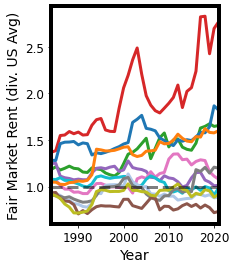

In [14]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(3, 4))
sns.lineplot(
    data=home_prices_regions,
    x="Year",
    y="relative_price",
    hue="areaname22",
    ax=ax,
    lw=3,
    palette=region_dict,
    legend=False
)
#ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax.set_xlim([1984, 2021])
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel("Fair Market Rent (div. US Avg)", fontsize=14)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
ax.spines['right'].set_linewidth(4)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.axhline(1, ls = 'dashed', lw=3, alpha = 0.5, color = 'k')


save_fig(FIGURE_DIR / 'fair-market-rent-relative')

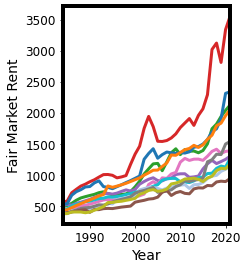

In [15]:
fig, ax = plt.subplots(figsize=(3, 4))
sns.lineplot(
    data=home_prices_regions, x="Year", y="value", hue="areaname22", ax=ax,
    lw=3,
    palette=region_dict,
    legend=False
)
#ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax.set_xlim([1984, 2021])
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel("Fair Market Rent", fontsize=14)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
ax.spines['right'].set_linewidth(4)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
save_fig(FIGURE_DIR / 'fair-market-rent')

### Fair market rent in 2021 dollars

In [16]:
home_prices_regions.columns = ['MSA', 'var', "price", "year", "relative_price"]

In [17]:
from datetime import date

In [18]:
import cpi

/home/AD/tsainbur/anaconda3/envs/postdoc/lib/python3.8/site-packages/cpi/__init__.py:46: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())


In [19]:
home_prices_regions[:3]

,MSA,var,price,year,relative_price
11,"San Diego-Carlsbad, CA MSA",fmr22_2,1979,2022,1.534985
12,"San Francisco, CA HUD Metro FMR Area",fmr22_2,3198,2022,2.480486
13,"Chicago-Joliet-Naperville, IL HUD Metro FMR Area",fmr22_2,1340,2022,1.039353


In [20]:
inflation_adjusted_price = []
for idx, row in home_prices_regions.iterrows():
    dollars_2021 = cpi.inflate(
        row.price,
        year_or_month=date(np.min([2021, row.year]), 1, 1),
        to=date(2021, 1, 1),
    )
    inflation_adjusted_price.append(dollars_2021)

In [21]:
home_prices_regions['inflation_adjusted_price_2021'] = inflation_adjusted_price

<ipython-input-21-50a0403df1e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_prices_regions['inflation_adjusted_price_2021'] = inflation_adjusted_price


In [28]:
home_prices_regions[:3]

,MSA,var,price,year,relative_price,inflation_adjusted_price_2021
11,"San Diego-Carlsbad, CA MSA",fmr22_2,1979,2022,1.534985,1979.0
12,"San Francisco, CA HUD Metro FMR Area",fmr22_2,3198,2022,2.480486,3198.0
13,"Chicago-Joliet-Naperville, IL HUD Metro FMR Area",fmr22_2,1340,2022,1.039353,1340.0


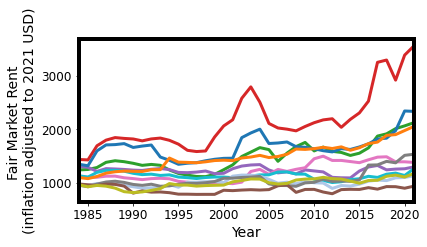

In [26]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.lineplot(
    data=home_prices_regions,
    x="year",
    y="inflation_adjusted_price_2021",
    hue="MSA",
    ax=ax,
    lw=3,
    palette=region_dict,
    legend=False
)
#ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax.set_xlim([1984, 2021])
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel("Fair Market Rent \n(inflation adjusted to 2021 USD)", fontsize=14)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
ax.spines['right'].set_linewidth(4)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
#ax.axhline(1, ls = 'dashed', lw=3, alpha = 0.5, color = 'k')


save_fig(FIGURE_DIR / 'fair-market-rent-inflation-adjusted')